In [1]:
!nvidia-smi

Thu Mar  9 01:15:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=7e162d83a7afcbbecddec5c4536fe3be35cb0b1c275aff8d0311ed2d5fa28e49
  Stored in directory: /root/.cache/pip/wheels/86/07/9f/879035d99d7b639bbc564d23fed862a679aee7d1a2dced8c2e
Successfully built ptflops


In [3]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchsummary import summary
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

In [4]:
# Define how we want images transformed
resize = (64, 64)
trans = transforms.Compose([transforms.Resize(resize),
                            transforms.ToTensor()])

# Create training and validation sets
training_set = torchvision.datasets.CIFAR10('./data', train=True, 
                                                 transform=trans, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, 
                                                   transform=trans, download=True)

# Create dataloaders for each set
training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, 
                                              shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, 
                                                shuffle=False, num_workers=2)


print("Training set size:", len(training_set))
print("Validation set size:", len(validation_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Validation set size: 10000


In [5]:
# Define the training loop for each epoch
def trainLoop(dataloader, model, loss_fn, optimizer):

    numBatches = len(dataloader)
    dataSize = len(dataloader.dataset)
    totalLoss = 0
    numCorrect = 0

    for batch, (X, y) in enumerate(dataloader):
    
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalLoss = totalLoss + loss.item()

        if batch % 100 == 0:
            loss = loss.item()
            interLosses.append(loss)
            avgLoss = totalLoss / (batch + 1)
            avgLosses.append(avgLoss) 
            print("loss:", loss)

        pred = model(X)
        numCorrect = numCorrect + (pred.argmax(1) == y).type(torch.float).sum().item()
    
    trainAcc = numCorrect / dataSize
    trainHist.append(trainAcc)
    trainAccPercent = trainAcc * 100
    
    epochLoss = totalLoss / len(dataloader)
    trainLosses.append(epochLoss)

    print("Training Accuracy: ", trainAccPercent,  "    Training Loss: ", epochLoss)

In [6]:
# Define the validation loop for each epoch
def valLoop(dataloader, model, loss_fn):
    
    numBatches = len(dataloader)
    dataSize = len(dataloader.dataset)
    valLoss = 0
    numCorrect = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            valLoss = valLoss + loss_fn(pred, y).item() 
            numCorrect = numCorrect + (pred.argmax(1) == y).type(torch.float).sum().item()

    
    valAcc = numCorrect / dataSize
    valHist.append(valAcc)
    valAccPercent = valAcc * 100

    avgLoss = valLoss / numBatches
    valLosses.append(avgLoss)
    
    print("Validation Accuracy:", valAccPercent, "    Validation Loss: ", avgLoss)
    print(" ")

# 1a) Baseline VGG-11

In [7]:
def VGGBlock(numConv, outChannels): 
  layers = []
  for _ in range(numConv):
     layers.append(nn.LazyConv2d(outChannels, kernel_size=3, padding=1)) 
     layers.append(nn.LazyBatchNorm2d())
     layers.append(nn.ReLU())

  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [8]:
def BaseVGG(arch):
  convBlocks = []
  for (numConv, outChannels) in arch:
    convBlocks.append(VGGBlock(numConv, outChannels))
  
  VGGNet = nn.Sequential(
            *convBlocks,
            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(512), nn.ReLU(), nn.Dropout(0.5),       # Adjusted from 4096 to better accomodate only 10 classes
            nn.LazyLinear(10)
        )
  return VGGNet

In [ ]:
VGGEleven = BaseVGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))
#summary(VGGEleven, input_size = (3, 64, 64), batch_size = 128)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#from torchvision import models
#model = models.vgg11()
#summary(model, input_size = (3, 64, 64), batch_size = 128)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGGEleven.parameters(), lr=0.01)

In [ ]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, VGGEleven, criterion, optimizer)
    valLoop(validation_loader, VGGEleven, criterion)

Epoch 1
loss: 2.322709798812866
loss: 1.7706522941589355
loss: 1.3530608415603638
loss: 1.3835805654525757
Training Accuracy:  49.206     Training Loss:  1.5973757987132158
Validation Accuracy: 51.190000000000005     Validation Loss:  1.3320431256596046
 
Epoch 2
loss: 1.2362195253372192
loss: 1.1561284065246582
loss: 1.2826095819473267
loss: 1.0891155004501343
Training Accuracy:  73.636     Training Loss:  1.1106922954244687
Validation Accuracy: 61.58     Validation Loss:  1.058244418494309
 
Epoch 3
loss: 0.9438884854316711
loss: 1.0084092617034912
loss: 0.854917049407959
loss: 0.83794105052948
Training Accuracy:  84.428     Training Loss:  0.8733290932367525
Validation Accuracy: 68.10000000000001     Validation Loss:  0.9052490395835683
 
Epoch 4
loss: 0.8517128825187683
loss: 0.8558422327041626
loss: 0.5831639170646667
loss: 0.8300999402999878
Training Accuracy:  90.956     Training Loss:  0.6997149263501472
Validation Accuracy: 70.89999999999999     Validation Loss:  0.84792962255

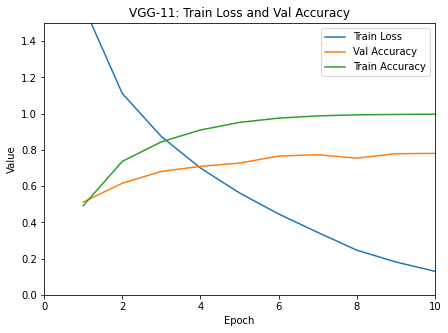

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("VGG-11: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~100ish mins for 10 epochs w/A100 GPU

In [ ]:
macs, params = get_model_complexity_info(VGGEleven, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  19.72 M, 100.000% Params, 624.48 MMac, 100.000% MACs, 
  (0): Sequential(
    1.92 k, 0.010% Params, 8.39 MMac, 1.343% MACs, 
    (0): Conv2d(1.79 k, 0.009% Params, 7.34 MMac, 1.175% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, 0.001% Params, 524.29 KMac, 0.084% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 262.14 KMac, 0.042% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 262.14 KMac, 0.042% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    74.11 k, 0.376% Params, 76.15 MMac, 12.195% MACs, 
    (0): Conv2d(73.86 k, 0.374% Params, 75.63 MMac, 12.111% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, 0.001% Params, 262.14 KMac, 0.042% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 131.07 KMac, 0.021% MACs, )
    (3): MaxPool

# 1b) VGG-16

In [ ]:
VGGSixteen = BaseVGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
#summary(VGGSixteen, input_size = (3, 64, 64), batch_size = 128)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGGSixteen.parameters(), lr=0.01)

In [ ]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, VGGSixteen, criterion, optimizer)
    valLoop(validation_loader, VGGSixteen, criterion)

Epoch 1
loss: 2.3159642219543457
loss: 1.7693490982055664
loss: 1.4039890766143799
loss: 1.376631498336792
Training Accuracy:  51.286     Training Loss:  1.5964810982384645
Validation Accuracy: 53.02     Validation Loss:  1.3110757688932781
 
Epoch 2
loss: 1.289994716644287
loss: 1.1914608478546143
loss: 1.2127760648727417
loss: 0.9775689840316772
Training Accuracy:  79.61399999999999     Training Loss:  1.0464261959275931
Validation Accuracy: 67.67     Validation Loss:  0.9252960327305372
 
Epoch 3
loss: 0.8221198320388794
loss: 0.9339970946311951
loss: 0.5893039703369141
loss: 0.7952086925506592
Training Accuracy:  90.17399999999999     Training Loss:  0.771403071368137
Validation Accuracy: 71.61     Validation Loss:  0.8031428788281694
 
Epoch 4
loss: 0.5304207801818848
loss: 0.3293275237083435
loss: 0.5665963888168335
loss: 0.5413843989372253
Training Accuracy:  95.468     Training Loss:  0.5896911217885858
Validation Accuracy: 75.36     Validation Loss:  0.7284090673621697
 
Epoch

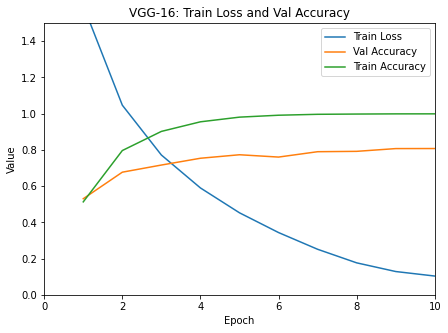

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("VGG-16: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~3hrs 15mins for 10 epochs 

In [ ]:
macs, params = get_model_complexity_info(VGGSixteen, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  25.22 M, 100.000% Params, 1.27 GMac, 100.000% MACs, 
  (0): Sequential(
    38.98 k, 0.155% Params, 160.43 MMac, 12.650% MACs, 
    (0): Conv2d(1.79 k, 0.007% Params, 7.34 MMac, 0.579% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, 0.001% Params, 524.29 KMac, 0.041% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 262.14 KMac, 0.021% MACs, )
    (3): Conv2d(36.93 k, 0.146% Params, 151.26 MMac, 11.927% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, 0.001% Params, 524.29 KMac, 0.041% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(0, 0.000% Params, 262.14 KMac, 0.021% MACs, )
    (6): MaxPool2d(0, 0.000% Params, 262.14 KMac, 0.021% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    221.95 k, 0.880% Params, 227.67 MMac, 17.952% MACs, 
    (0): Conv

# 1c) VGG-19

In [9]:
VGGNineteen = BaseVGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))
#summary(VGGNineteen, input_size = (3, 64, 64), batch_size = 128)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGGNineteen.parameters(), lr=0.01)

In [11]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, VGGNineteen, criterion, optimizer)
    valLoop(validation_loader, VGGNineteen, criterion)

Epoch 1
loss: 2.331387758255005
loss: 1.7032594680786133
loss: 1.526144027709961
loss: 1.3765671253204346
Training Accuracy:  52.334     Training Loss:  1.6046475733027739
Validation Accuracy: 52.459999999999994     Validation Loss:  1.2993437293209606
 
Epoch 2
loss: 1.4717752933502197
loss: 1.3382675647735596
loss: 1.0125163793563843
loss: 0.863140881061554
Training Accuracy:  81.314     Training Loss:  1.050951664709984
Validation Accuracy: 67.53     Validation Loss:  0.925742282143122
 
Epoch 3
loss: 0.9831904768943787
loss: 0.7725498080253601
loss: 0.6669642329216003
loss: 0.8635208606719971
Training Accuracy:  91.85600000000001     Training Loss:  0.76711285967961
Validation Accuracy: 70.05     Validation Loss:  0.8731882028941866
 
Epoch 4
loss: 0.7225092053413391
loss: 0.5570181608200073
loss: 0.5194321274757385
loss: 0.580623984336853
Training Accuracy:  96.26400000000001     Training Loss:  0.5837884024738351
Validation Accuracy: 77.17     Validation Loss:  0.6869940467273132

KeyboardInterrupt: ignored

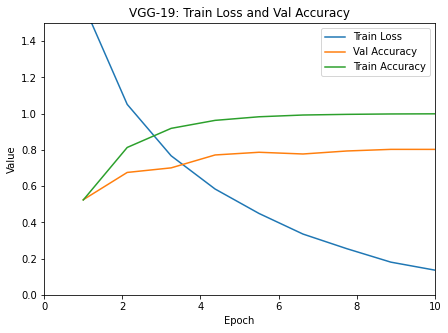

In [13]:
# Plot results
x = np.linspace(1, epochs, epochs-1)     
plt.figure(figsize=(7,5))
plt.title("VGG-19: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~3hrs 30mins for 9 epochs 

In [14]:
macs, params = get_model_complexity_info(VGGNineteen, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  30.53 M, 100.000% Params, 1.61 GMac, 100.000% MACs, 
  (0): Sequential(
    38.98 k, 0.128% Params, 160.43 MMac, 9.975% MACs, 
    (0): Conv2d(1.79 k, 0.006% Params, 7.34 MMac, 0.456% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, 0.000% Params, 524.29 KMac, 0.033% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 262.14 KMac, 0.016% MACs, )
    (3): Conv2d(36.93 k, 0.121% Params, 151.26 MMac, 9.404% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, 0.000% Params, 524.29 KMac, 0.033% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(0, 0.000% Params, 262.14 KMac, 0.016% MACs, )
    (6): MaxPool2d(0, 0.000% Params, 262.14 KMac, 0.016% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    221.95 k, 0.727% Params, 227.67 MMac, 14.155% MACs, 
    (0): Conv2d

# 2a) Baseline GoogleNet 

In [ ]:
class Inception(nn.Module):

    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [ ]:
bigBlock1 = nn.Sequential(
                   nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
bigBlock2 = nn.Sequential(
                   nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
                   nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock3 = nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                   Inception(128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock4 = nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                   Inception(160, (112, 224), (24, 64), 64),
                   Inception(128, (128, 256), (24, 64), 64),
                   Inception(112, (144, 288), (32, 64), 64),
                   Inception(256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock5 = nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                   Inception(384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)), 
                   nn.Flatten())

In [ ]:
GoogleNet = nn.Sequential(
    bigBlock1,
    bigBlock2,
    bigBlock3,
    bigBlock4,
    bigBlock5,
    nn.LazyLinear(10)
)

In [ ]:
summary(GoogleNet, input_size = (3, 64, 64), batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 32, 32]           9,472
              ReLU-2          [128, 64, 32, 32]               0
         MaxPool2d-3          [128, 64, 16, 16]               0
            Conv2d-4          [128, 64, 16, 16]           4,160
              ReLU-5          [128, 64, 16, 16]               0
            Conv2d-6         [128, 192, 16, 16]         110,784
              ReLU-7         [128, 192, 16, 16]               0
         MaxPool2d-8           [128, 192, 8, 8]               0
            Conv2d-9            [128, 64, 8, 8]          12,352
           Conv2d-10            [128, 96, 8, 8]          18,528
           Conv2d-11           [128, 128, 8, 8]         110,720
           Conv2d-12            [128, 16, 8, 8]           3,088
           Conv2d-13            [128, 32, 8, 8]          12,832
        MaxPool2d-14           [128, 19

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(GoogleNet.parameters(), lr=0.01)

In [ ]:
# Begin training over 5 epochs
epochs = 5
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, GoogleNet, criterion, optimizer)
    valLoop(validation_loader, GoogleNet, criterion)

Epoch 1
loss: 2.304359197616577
loss: 2.302676200866699
loss: 2.302182674407959
loss: 2.302480936050415
Training Accuracy:  10.0     Training Loss:  2.302677970408174
Validation Accuracy: 10.0     Validation Loss:  2.302629262586183
 
Epoch 2
loss: 2.3016629219055176
loss: 2.3033292293548584
loss: 2.302647590637207
loss: 2.302816152572632
Training Accuracy:  10.07     Training Loss:  2.302648488213034
Validation Accuracy: 10.0     Validation Loss:  2.3026042165635507
 
Epoch 3
loss: 2.302588939666748
loss: 2.3023459911346436
loss: 2.3028881549835205
loss: 2.303091526031494
Training Accuracy:  10.25     Training Loss:  2.3026394051359134
Validation Accuracy: 10.0     Validation Loss:  2.302596753156638
 
Epoch 4
loss: 2.302618980407715
loss: 2.3027374744415283
loss: 2.3028383255004883
loss: 2.302997350692749
Training Accuracy:  10.209999999999999     Training Loss:  2.302632306847731
Validation Accuracy: 10.0     Validation Loss:  2.3025873974908757
 
Epoch 5
loss: 2.3026015758514404
lo

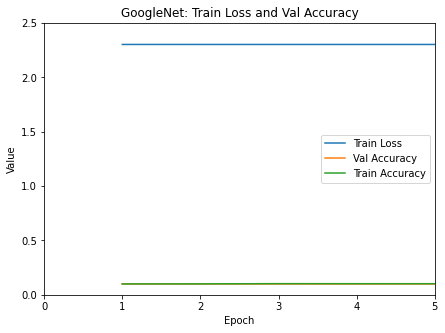

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("GoogleNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 2.5)
plt.show()

### Train time: ~18ish minutes for 5 epochs 

In [ ]:
macs, params = get_model_complexity_info(GoogleNet, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  5.98 M, 100.000% Params, 129.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.47 k, 0.158% Params, 9.83 MMac, 7.576% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.475% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(0, 0.000% Params, 65.54 KMac, 0.051% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.051% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    114.94 k, 1.921% Params, 29.54 MMac, 22.766% MACs, 
    (0): Conv2d(4.16 k, 0.070% Params, 1.06 MMac, 0.821% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(0, 0.000% Params, 16.38 KMac, 0.013% MACs, )
    (2): Conv2d(110.78 k, 1.851% Params, 28.36 MMac, 21.857% MACs, 64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 49.15 KMac, 0.038% MACs, )
    (4): MaxPool2d(0, 0.000% Params, 49.15 KMac, 0.038% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False

# 2b) GoogleNet w/ Batchnorm

In [ ]:
class BatchInception(nn.Module):

    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(BatchInception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        self.b1_bn = nn.LazyBatchNorm2d()
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_1_bn = nn.LazyBatchNorm2d()
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.b2_2_bn = nn.LazyBatchNorm2d()
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_1_bn = nn.LazyBatchNorm2d()
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        self.b3_2_bn = nn.LazyBatchNorm2d()
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
        self.b4_bn = nn.LazyBatchNorm2d()

    def forward(self, x):
        b1 = self.b1_bn( F.relu(self.b1_1(x)) )
        b2 = F.relu(self.b2_2_bn( self.b2_2(F.relu(self.b2_1_bn( self.b2_1(x) ))) ))
        b3 = F.relu(self.b3_2_bn( self.b3_2(F.relu(self.b3_1_bn( self.b3_1(x) ))) ))
        b4 = F.relu(self.b4_bn( self.b4_2(self.b4_1(x)) ))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [ ]:
bigBlock1 = nn.Sequential(
                          nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.LazyBatchNorm2d(), nn.ReLU(), 
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock2 = nn.Sequential(
                          nn.LazyConv2d(64, kernel_size=1), nn.LazyBatchNorm2d(), nn.ReLU(),
                          nn.LazyConv2d(192, kernel_size=3, padding=1), nn.LazyBatchNorm2d(), nn.ReLU(),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock3 = nn.Sequential(BatchInception(64, (96, 128), (16, 32), 32),
                          BatchInception(128, (128, 192), (32, 96), 64),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock4 = nn.Sequential(BatchInception(192, (96, 208), (16, 48), 64),
                          BatchInception(160, (112, 224), (24, 64), 64),
                          BatchInception(128, (128, 256), (24, 64), 64),
                          BatchInception(112, (144, 288), (32, 64), 64),
                          BatchInception(256, (160, 320), (32, 128), 128),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
bigBlock5 = nn.Sequential(BatchInception(256, (160, 320), (32, 128), 128),
                          BatchInception(384, (192, 384), (48, 128), 128),
                          nn.AdaptiveAvgPool2d((1,1)), 
                          nn.Flatten())

In [ ]:
BatchGoogleNet = nn.Sequential(
    bigBlock1,
    bigBlock2,
    bigBlock3,
    bigBlock4,
    bigBlock5,
    nn.LazyLinear(10)
)

In [ ]:
summary(BatchGoogleNet, input_size = (3, 64, 64), batch_size = 128)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(BatchGoogleNet.parameters(), lr=0.01)

In [ ]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, BatchGoogleNet, criterion, optimizer)
    valLoop(validation_loader, BatchGoogleNet, criterion)

Epoch 1
loss: 2.4031636714935303
loss: 1.5241669416427612
loss: 1.5519462823867798
loss: 1.412006139755249
Training Accuracy:  72.332     Training Loss:  1.5833526383275571
Validation Accuracy: 51.55     Validation Loss:  1.3400464057922363
 
Epoch 2
loss: 1.2369741201400757
loss: 1.211909532546997
loss: 1.2887994050979614
loss: 1.0961852073669434
Training Accuracy:  84.646     Training Loss:  1.1801138774818167
Validation Accuracy: 59.78     Validation Loss:  1.1172009359432171
 
Epoch 3
loss: 0.9839455485343933
loss: 1.060718297958374
loss: 0.8656967282295227
loss: 0.9972230792045593
Training Accuracy:  89.446     Training Loss:  0.9750528414840893
Validation Accuracy: 64.71000000000001     Validation Loss:  0.9899978622605529
 
Epoch 4
loss: 0.8221462368965149
loss: 0.6781387329101562
loss: 0.63700270652771
loss: 0.7727214694023132
Training Accuracy:  93.53200000000001     Training Loss:  0.8216175238799561
Validation Accuracy: 66.81     Validation Loss:  0.9690882918200915
 
Epoch 

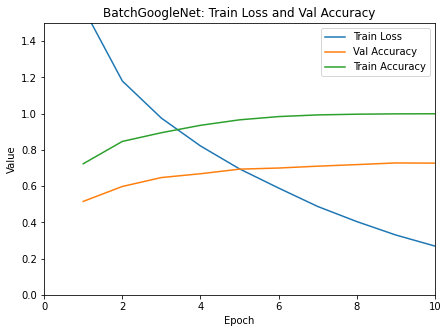

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("BatchGoogleNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~45ish minutes for 10 epochs 

In [ ]:
macs, params = get_model_complexity_info(BatchGoogleNet, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  6.0 M, 100.000% Params, 130.28 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.160% Params, 9.96 MMac, 7.646% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.445% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.002% Params, 131.07 KMac, 0.101% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.050% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.050% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    115.46 k, 1.925% Params, 29.67 MMac, 22.774% MACs, 
    (0): Conv2d(4.16 k, 0.069% Params, 1.06 MMac, 0.817% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, 0.002% Params, 32.77 KMac, 0.025% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 16.38 KMac, 0.013% MACs, )
    (3): Conv2d(110.78 k, 1.847% Params, 28.

# 3a) Baseline ResNet-18

In [ ]:
class Residual(nn.Module): 

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
def ResBlock(num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    
    return nn.Sequential(*blk)

In [ ]:
def body(arch):
    bodyBlocks = []
    for i, b in enumerate(arch):
        bodyBlocks.append(ResBlock(*b, first_block=(i==0)))
    
    return nn.Sequential(*bodyBlocks)

In [ ]:
resBigBlock1 = nn.Sequential(
               nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
               nn.LazyBatchNorm2d(), nn.ReLU(),
               nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
resBigBlock2 = body(((2, 64), (2, 128), (2, 256), (2, 512)))

In [ ]:
resBigBlock3 = nn.Sequential(
               nn.AdaptiveAvgPool2d((1, 1)), 
               nn.Flatten(),
               nn.LazyLinear(10))

In [ ]:
ResNet18 = nn.Sequential(
    resBigBlock1,
    resBigBlock2,
    resBigBlock3
)

In [ ]:
summary(ResNet18, input_size = (3, 64, 64), batch_size = 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 32, 32]           9,472
       BatchNorm2d-2          [128, 64, 32, 32]             128
              ReLU-3          [128, 64, 32, 32]               0
         MaxPool2d-4          [128, 64, 16, 16]               0
            Conv2d-5          [128, 64, 16, 16]          36,928
       BatchNorm2d-6          [128, 64, 16, 16]             128
            Conv2d-7          [128, 64, 16, 16]          36,928
       BatchNorm2d-8          [128, 64, 16, 16]             128
          Residual-9          [128, 64, 16, 16]               0
           Conv2d-10          [128, 64, 16, 16]          36,928
      BatchNorm2d-11          [128, 64, 16, 16]             128
           Conv2d-12          [128, 64, 16, 16]          36,928
      BatchNorm2d-13          [128, 64, 16, 16]             128
         Residual-14          [128, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01)

In [ ]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ResNet18, criterion, optimizer)
    valLoop(validation_loader, ResNet18, criterion)

Epoch 1
loss: 2.462340831756592
loss: 1.4582386016845703
loss: 1.2948322296142578
loss: 1.19211745262146
Training Accuracy:  78.89     Training Loss:  1.373415850160067
Validation Accuracy: 59.18     Validation Loss:  1.1354249217842198
 
Epoch 2
loss: 0.8900984525680542
loss: 0.8996784090995789
loss: 1.100325584411621
loss: 0.9876412153244019
Training Accuracy:  90.736     Training Loss:  0.9518261593016212
Validation Accuracy: 64.22     Validation Loss:  1.0047412620315068
 
Epoch 3
loss: 0.9186182618141174
loss: 0.7010466456413269
loss: 0.7943851351737976
loss: 0.7852962017059326
Training Accuracy:  96.352     Training Loss:  0.7352850441737553
Validation Accuracy: 68.28     Validation Loss:  0.9230640470227108
 
Epoch 4
loss: 0.5784720182418823
loss: 0.5407695770263672
loss: 0.555677592754364
loss: 0.4433528780937195
Training Accuracy:  98.976     Training Loss:  0.570110267842822
Validation Accuracy: 69.77     Validation Loss:  0.8741352377058584
 
Epoch 5
loss: 0.588233232498169


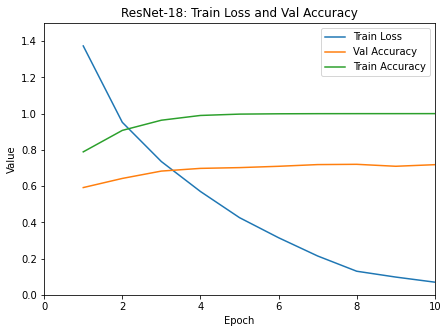

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("ResNet-18: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~32ish minutes for 10 epochs 

In [ ]:
macs, params = get_model_complexity_info(ResNet18, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  11.18 M, 100.000% Params, 148.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.086% Params, 9.96 MMac, 6.696% MACs, 
    (0): Conv2d(9.47 k, 0.085% Params, 9.7 MMac, 6.520% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.044% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    11.17 M, 99.868% Params, 138.8 MMac, 93.299% MACs, 
    (0): Sequential(
      148.22 k, 1.325% Params, 37.95 MMac, 25.507% MACs, 
      (0): Residual(
        74.11 k, 0.663% Params, 18.97 MMac, 12.754% MACs, 
        (conv1): Conv2d(36.93 k, 0.330% Params, 9.45 MMac, 6.355% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(36.93 k, 0.330% Params, 9.4

# 3b) ResNet-26

In [ ]:
res26BigBlock1 = nn.Sequential(
                 nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                 nn.LazyBatchNorm2d(), nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
res26BigBlock2 = body(((2, 64), (3, 128), (4, 256), (2, 512)))

In [ ]:
res26BigBlock3 = nn.Sequential(
                 nn.AdaptiveAvgPool2d((1, 1)), 
                 nn.Flatten(),
                 nn.LazyLinear(10))

In [ ]:
ResNet26 = nn.Sequential(
    res26BigBlock1,
    res26BigBlock2,
    res26BigBlock3
)

# 3c) ResNet-32

In [ ]:
res32BigBlock1 = nn.Sequential(
                 nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                 nn.LazyBatchNorm2d(), nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
res32BigBlock2 = body(((3, 64), (4, 128), (6, 256), (3, 512)))

In [ ]:
res32BigBlock3 = nn.Sequential(
                 nn.AdaptiveAvgPool2d((1, 1)), 
                 nn.Flatten(),
                 nn.LazyLinear(10))

In [ ]:
ResNet32 = nn.Sequential(
    res32BigBlock1,
    res32BigBlock2,
    res32BigBlock3
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet32.parameters(), lr=0.01)

In [ ]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ResNet32, criterion, optimizer)
    valLoop(validation_loader, ResNet32, criterion)

Epoch 1
loss: 2.511591911315918
loss: 1.5542881488800049
loss: 1.4366211891174316
loss: 1.3692954778671265
Training Accuracy:  80.294     Training Loss:  1.4604977520225604
Validation Accuracy: 57.28     Validation Loss:  1.1836518237862406
 
Epoch 2
loss: 0.9406509399414062
loss: 1.0219050645828247
loss: 0.9520958065986633
loss: 1.0801548957824707
Training Accuracy:  90.53999999999999     Training Loss:  1.0455130475866214
Validation Accuracy: 63.9     Validation Loss:  1.0262688322912288
 
Epoch 3
loss: 0.9648037552833557
loss: 1.0323445796966553
loss: 0.870963454246521
loss: 0.7506881952285767
Training Accuracy:  96.11     Training Loss:  0.8135033060827523
Validation Accuracy: 67.92     Validation Loss:  0.926001138324979
 
Epoch 4
loss: 0.6214495897293091
loss: 0.5398983359336853
loss: 0.7081708312034607
loss: 0.6848787069320679
Training Accuracy:  98.556     Training Loss:  0.6495592630732699
Validation Accuracy: 68.30000000000001     Validation Loss:  0.9299038437348378
 
Epoch 

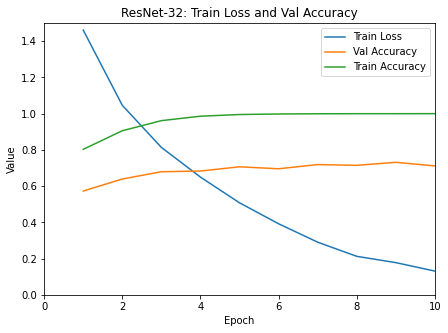

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("ResNet-32: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: 60 minutes for 10 epochs 

In [ ]:
macs, params = get_model_complexity_info(ResNet32, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  21.3 M, 100.000% Params, 300.07 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.045% Params, 9.96 MMac, 3.320% MACs, 
    (0): Conv2d(9.47 k, 0.044% Params, 9.7 MMac, 3.232% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.044% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.022% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.022% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    21.28 M, 99.931% Params, 290.1 MMac, 96.678% MACs, 
    (0): Sequential(
      222.34 k, 1.044% Params, 56.92 MMac, 18.969% MACs, 
      (0): Residual(
        74.11 k, 0.348% Params, 18.97 MMac, 6.323% MACs, 
        (conv1): Conv2d(36.93 k, 0.173% Params, 9.45 MMac, 3.150% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(36.93 k, 0.173% Params, 9.45 

# Extra) DenseNet vs. ResNet

In [ ]:
def convBlockDense(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(convBlockDense(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [ ]:
def transitionBlock(num_channels):
    return nn.Sequential(
                        nn.LazyBatchNorm2d(), nn.ReLU(),
                        nn.LazyConv2d(num_channels, kernel_size=1),
                        nn.AvgPool2d(kernel_size=2, stride=2)
                 )

In [ ]:
def denseBody(arch):
    growthRate = 32
    bodyBlocks = []
    numChannels = 64

    for i, numConvs in enumerate(arch):
        bodyBlocks.append(DenseBlock(numConvs, growthRate))
        numChannels += numConvs * growthRate

        if i != len(arch) - 1:
            numChannels //= 2
            bodyBlocks.append(transitionBlock(numChannels))
    
    return nn.Sequential(*bodyBlocks)

In [ ]:
denseBigBlock1 = nn.Sequential(
                        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                        nn.LazyBatchNorm2d(), nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                 )

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
denseBigBlock2 = denseBody((4,16,9,18,21))

In [ ]:
denseBigBlock3 = nn.Sequential(
                        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
                        nn.LazyLinear(10)
)

In [ ]:
denseNet = nn.Sequential(
                        denseBigBlock1,
                        denseBigBlock2,
                        denseBigBlock3
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(denseNet.parameters(), lr=0.01)

In [ ]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, denseNet, criterion, optimizer)
    valLoop(validation_loader, denseNet, criterion)

Epoch 1
loss: 2.305583953857422
loss: 1.5611282587051392
loss: 1.2717264890670776
loss: 1.160510540008545
Training Accuracy:  60.132     Training Loss:  1.4740133767237749
Validation Accuracy: 58.209999999999994     Validation Loss:  1.1806575874739056
 
Epoch 2
loss: 1.1500059366226196
loss: 1.0796420574188232
loss: 1.113866925239563
loss: 0.9303102493286133
Training Accuracy:  83.016     Training Loss:  1.0109011655878228
Validation Accuracy: 66.69     Validation Loss:  0.9380505990378464
 
Epoch 3
loss: 0.7960896492004395
loss: 0.725610613822937
loss: 0.8983271718025208
loss: 0.9390447735786438
Training Accuracy:  91.4     Training Loss:  0.7970694048935191
Validation Accuracy: 70.63000000000001     Validation Loss:  0.8357654304444035
 
Epoch 4
loss: 0.6795663833618164
loss: 0.499089777469635
loss: 0.7130162119865417
loss: 0.5280178189277649
Training Accuracy:  95.44200000000001     Training Loss:  0.6470762312869587
Validation Accuracy: 72.67     Validation Loss:  0.78924592386318

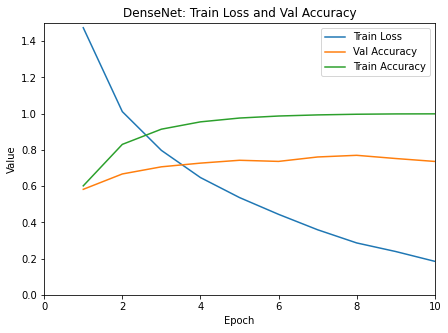

In [ ]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("DenseNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~60 minutes for 10 epochs 

In [ ]:
macs, params = get_model_complexity_info(denseNet, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  11.17 M, 100.000% Params, 199.44 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.086% Params, 9.96 MMac, 4.995% MACs, 
    (0): Conv2d(9.47 k, 0.085% Params, 9.7 MMac, 4.863% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.066% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.033% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.033% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    11.15 M, 99.815% Params, 189.47 MMac, 94.999% MACs, 
    (0): DenseBlock(
      130.05 k, 1.164% Params, 33.41 MMac, 16.750% MACs, 
      (net): Sequential(
        130.05 k, 1.164% Params, 33.41 MMac, 16.750% MACs, 
        (0): Sequential(
          18.59 k, 0.166% Params, 4.78 MMac, 2.395% MACs, 
          (0): BatchNorm2d(128, 0.001% Params, 32.77 KMac, 0.016% MACs, 64, eps=1e-05, momen